# Joint analysis of the "new to nature" space

1. Convert the enzyme variant to amino acids based on the AAs and be warned about 1 vs 0 so need to check
2. Calculate concentration rather than yield (if yield is given then yield * mmol concentration)
3. Normalize to parent for each column (TTN, Yield)
4. Embeddings sequences
5. Convert to LevSeq format

# Look at the embedding spaces independently and jointly



In [48]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

protein_ded_df = pd.read_pickle('output/protein-evolution-database_V4_embedded_proteins.pkl')
protein_natural_df = pd.read_pickle('output/uniprotkb_reviewed_true_2025_17_02_ESM_3B_complete.pkl')

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/sit

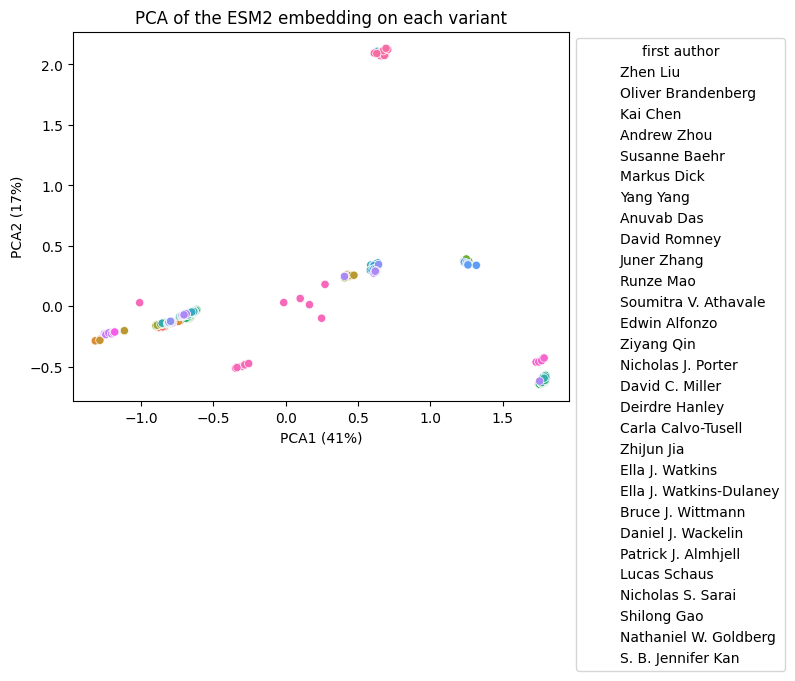

In [49]:
pca = PCA(n_components=2)
X = np.array([x for x in protein_ded_df['embedding'].values])

pca_values = pca.fit_transform(X)
protein_ded_df['PCA1'] = pca_values[:, 0]
protein_ded_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(protein_ded_df, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

## Look at this compared to natural enzymes 

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/sit

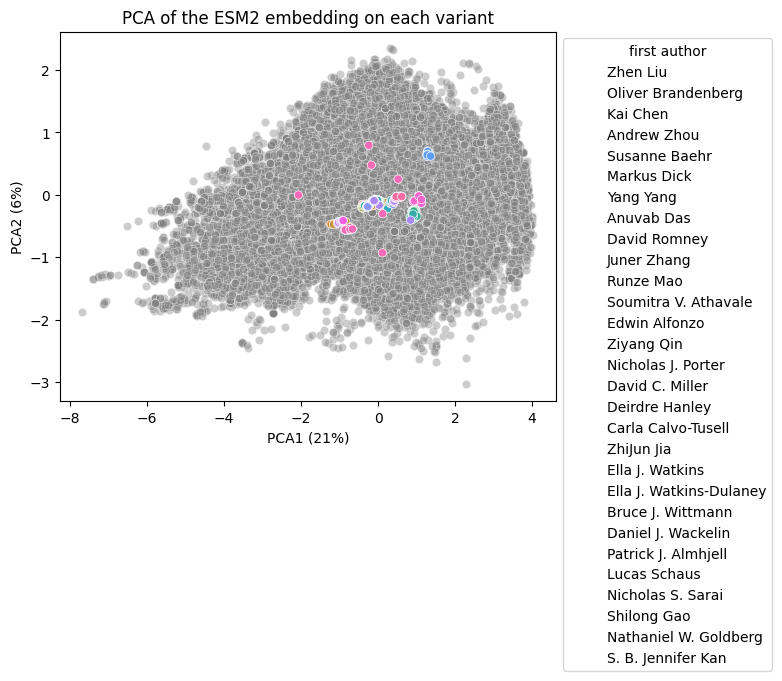

In [50]:
protein_natural_df['first author'] = 'Natural'

all_rxns = pd.concat([protein_ded_df, protein_natural_df])
pca = PCA(n_components=2)
X = np.array([x for x in all_rxns['embedding'].values]).reshape((len(all_rxns), len(all_rxns['embedding'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', color='grey', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', hue='first author')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

# Convert to concentration from yield

If activity is reported, convert with the substrate concentration to the activity_for_reaction_% (if applicable) otherwise multiply TTN.

In [51]:
def convert_to_yield(df, activity_col, substrate_conc_col):
    calc_yield = []
    errors = []
    for activity, substrate_mol in df[[activity_col, substrate_conc_col]].values:
        if substrate_mol:
            # Convert the substrate concentration to molar
            if 'mM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('mM')[0].replace(' ', '')) * (10**(-3)) # divide by 1000
            elif 'nM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('nM')[0].replace(' ', '')) * (10**(-9)) # divide by 10-9
            elif 'uM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('uM')[0].replace(' ', '')) * (10**(-6)) # divide by 1000
            elif 'M' in substrate_mol:
                substrate_mol = float(substrate_mol.split('M').replace(' ', ''))
            else:
                substrate_mol = None
                calc_yield.append(None)
                errors.append(f'substrate mol had no concentrations, {substrate_mol}')
                continue
        else:
            calc_yield.append(None)
            errors.append(f'No mol: {substrate_mol}')
            continue
        if activity != '?':
            # If had `<` or `>` we just remove
            if '>' in activity or '<' in activity:
                activity = activity.replace('>', '')
                activity = activity.replace('<', '')
                errors.append('Had a > or <')
            elif activity == 'trace':
                activity = 0.0001
                errors.append('Trace activity, used 0.0001')
            else:
                errors.append(None)
            activity = float(activity)
            calc_yield.append(activity*substrate_mol)
        else:
            errors.append(f'No activity, {substrate_mol}')
            calc_yield.append(None)
    return calc_yield, errors

calc_yield, errors = convert_to_yield(protein_ded_df, 'activity_for_reaction_% (if applicable)', 'substrate_concentration')
protein_ded_df['yield_from_activity'] = calc_yield
protein_ded_df['errors_from_activity'] = errors

calc_yield, errors = convert_to_yield(protein_ded_df, 'TTN (if applicable)', 'substrate_concentration')
protein_ded_df['yield_from_TTN'] = calc_yield
protein_ded_df['TTN_errors'] = errors

# Look at the reactions before joining again all together


Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/sit

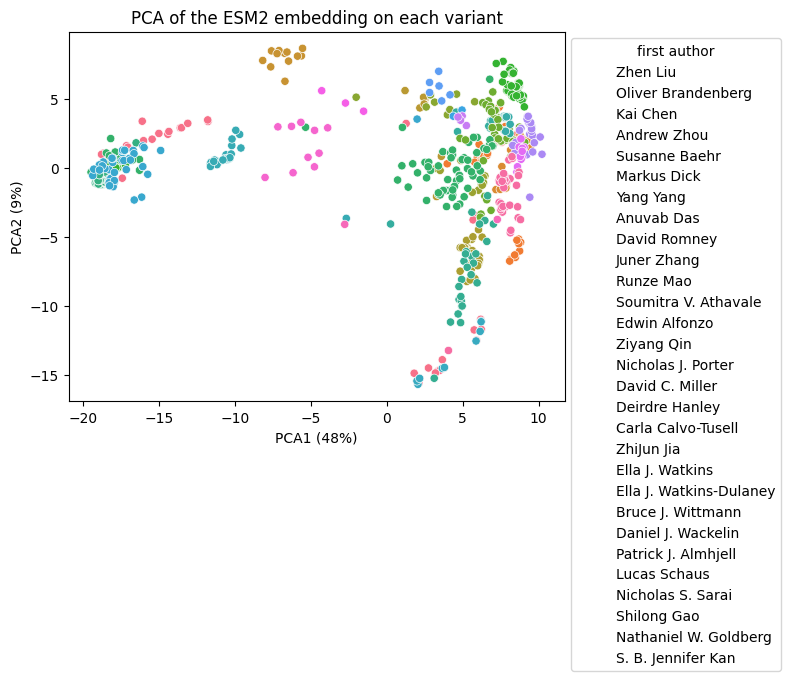

In [52]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)

rxn_ded_df = pd.read_pickle('output/rxn_rxnfp.pkl')

X = np.array([x for x in rxn_ded_df['rxnfp'].values]).reshape((len(rxn_ded_df), len(rxn_ded_df['rxnfp'].values[0])))

pca_values = pca.fit_transform(X)
rxn_ded_df['PCA1'] = pca_values[:, 0]
rxn_ded_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(rxn_ded_df, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/sit

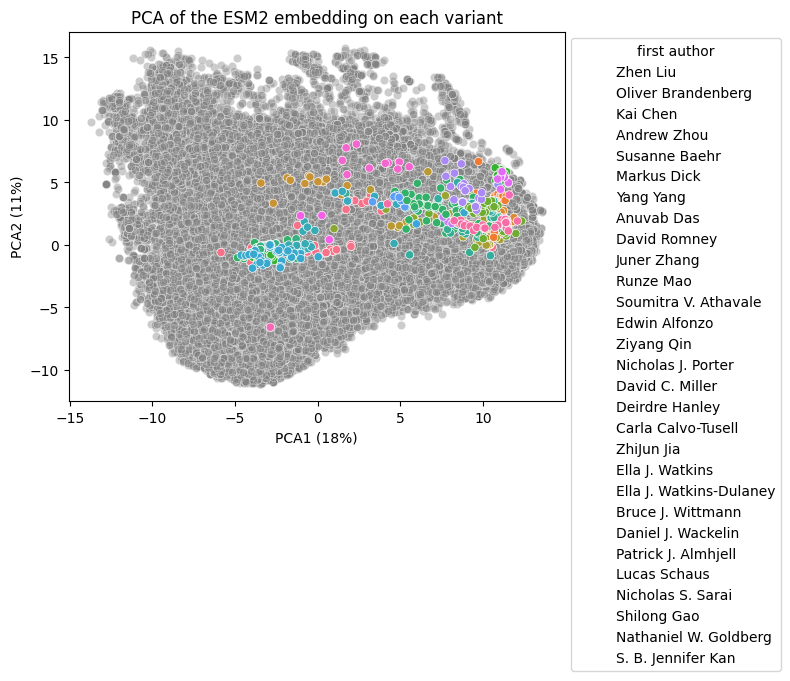

In [53]:
rxn_natural_df = pd.read_pickle('output/enzymemap_v2_brenda2023_reactions.pkl')
rxn_natural_df['first author'] = 'Natural'
all_rxns = pd.concat([rxn_natural_df, rxn_ded_df])
pca = PCA(n_components=2)
X = np.array([x for x in all_rxns['rxnfp'].values]).reshape((len(all_rxns), len(all_rxns['rxnfp'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

hue_order = [ 'Natural',
             'Andrew Zhou',
             'Anuvab Das',
             'Bruce J. Wittmann',
             'Carla Calvo-Tusell ',
             'Daniel J. Wackelin',
             'David C. Miller',
             'David Romney',
             'Deirdre Hanley',
             'Edwin Alfonzo',
             'Ella J. Watkins',
             'Ella J. Watkins-Dulaney',
             'Juner Zhang',
             'Kai Chen',
             'Lucas Schaus',
             'Markus Dick',
             'Nathaniel W. Goldberg',
             'Nicholas J. Porter',
             'Nicholas S. Sarai',
             'Oliver Brandenberg',
             'Patrick J. Almhjell',
             'Runze Mao',
             'S. B. Jennifer Kan',
             'Shilong Gao',
             'Soumitra V. Athavale',
             'Susanne Baehr',
             'Yang Yang',
             'Zhen Liu',
             'ZhiJun Jia',
             'Ziyang Qin']

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', color='grey', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', hue='first author')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

# Now we're going to join the two i.e. combine both of the enzyme/protein embeddings

In [54]:
rxn_natural_df = rxn_natural_df.drop_duplicates(subset=['ec_num'])
protein_natural_df = protein_natural_df.drop_duplicates(subset=['EC number'])
print(len(rxn_natural_df), len(protein_natural_df))

4552 6804


In [55]:
# Join the two 
rxn_natural_df = rxn_natural_df.set_index('ec_num')
protein_natural_df = protein_natural_df.set_index('EC number')
natural_df = rxn_natural_df.join(protein_natural_df, lsuffix='_protein', how='inner')
natural_df

,Unnamed: 0_protein,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,...,Residue_1index,active_site_residue_counts,active_encodings,Polarity,temperature,temp_level,cofactor,cofactor_encodings,embedding,first author
3.1.3.12,217697,207073,[O:2]=[P:3]([OH:4])([OH:5])[O:6][CH2:7][C@H:8]...,O.O=P(O)(O)OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@...,"alpha,alpha-trehalose 6-phosphate + H2O = alph...",[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,single,1.000000,...,215,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,['Mg(2+)'],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"[0.01774806, -0.06680477, -0.0014534739, -0.01...",Natural
3.1.1.81,213467,202567,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:7...,CCCCCC(=O)N[C@H]1CCOC1=O.O>>CCCCCC(=O)N[C@@H](...,N-hexanoyl-L-homoserine lactone + H2O = N-hexa...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct,single,0.973366,...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,species,[Zn(2+)],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.036601048, -0.025433065, -0.0018129623, -0...",Natural
1.2.1.44,82865,67205,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,4-coumaroyl-CoA + NADPH + H+ = 4-coumaraldehyd...,[#6:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[#...,100,direct,single,1.000000,...,165,1,[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.011697134, 0.03570128, 0.03830788, -0.00098...",Natural
2.5.1.18,155319,147675,[NH2:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[NH...,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O...,"1-chloro-2,4-dinitrobenzene + glutathione = S-...",[#16:1].[#6:2]-[#17:3]>>[#17:3].[#6:2]-[#16:1],325,direct,single,0.907895,...,NaN,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.019245792, 0.009193553, 0.039562628, -0.04...",Natural
3.2.1.37,242182,228243,[O:2]=[N+:3]([O-:4])[c:5]1[cH:6][cH:7][c:8]([O...,O.O=[N+]([O-])c1ccc(O[C@@H]2OC[C@@H](O)[C@H](O...,4-nitrophenyl beta-D-xyloside + H2O = 4-nitrop...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,single,0.998243,...,288,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,31.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.048603408, -0.012662074, -0.037163626, -0....",Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.3.1.41,128332,117826,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,Malonyl-CoA = Acetyl-CoA + CO2,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],92,direct,single,1.000000,...,163|298|333,3,[1. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.333333,36.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.040636655, -0.0023630767, -0.041519113, -0...",Natural
2.3.1.39,128261,117589,[CH3:19][C:20]([CH3:21])([CH2:22][O:23][P:24](...,CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)NCCS.CC(C)(COP(...,malonyl-CoA + pantetheine = malonyl-pantethein...,[#6:1]-[#16:2].[#7:3]>>[#16:2].[#6:1]-[#7:3],283,direct,single,0.333333,...,153|270,2,[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. ...,0.500000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.043407224, -0.016215881, 0.056216322, -0.0...",Natural
2.4.1.102,138185,128878,[CH3:1][C:2](=[O:3])[NH:4][C@H:5]1[C@@H:6]([O:...,CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2...,UDP-N-acetyl-D-glucosamine + beta-D-galactosyl...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,multi,1.000000,...,320,1,[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1.000000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.016544254, 0.09660754, 0.056120165, -0.0358...",Natural
2.4.1.117,138575,129416,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CC/C(C)=C...,UDP-glucose + dolichyl phosphate = UD

# Read in the database file with no errors and then join the two


Join rxn_ded_df using reaction_smiles and then also join the protein embedding DF using the 

In [80]:
df = pd.read_csv('output/protein-evolution-database_V4_proteins_reactions_clean.csv', index_col=0)
# Map between protein embeddings based on the id
id_to_protein_embedding = dict(zip(protein_ded_df.variant_aa, protein_ded_df.embedding))
# Also do the reaction
reaction_to_embedding = dict(zip(rxn_ded_df.reaction_smiles, rxn_ded_df.rxnfp))
df['protein_ESM3B'] = [id_to_protein_embedding.get(i) for i in df['variant_aa'].values]
df['reaction_rxnfp'] = [reaction_to_embedding.get(i) for i in df['reaction_smiles'].values]
df.to_pickle('output/protein-evolution-database_V4_ALL.pkl')

# Now we can plot the reaction and the protein PCA's against one another

In [81]:
pca = PCA(n_components=2)
df = df.dropna(subset=['protein_ESM3B'])
X = np.array([x for x in df['protein_ESM3B'].values])

pca_values = pca.fit_transform(X)
df['PCA1_protein_ESM3B'] = pca_values[:, 0]
df['PCA2_protein_ESM3B'] = pca_values[:, 1]

# Now do the same for the reaction
df = df.dropna(subset=['reaction_rxnfp'])
X = np.array([x for x in df['reaction_rxnfp'].values])

pca_values = pca.fit_transform(X)
df['PCA1_reaction_rxnfp'] = pca_values[:, 0]
df['PCA2_reaction_rxnfp'] = pca_values[:, 1]


Text(0.5, 1.0, 'PCA of the ESM2 embedding with RXNFP')

/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arianemora/miniconda3/envs/etk/lib/python3.11/sit

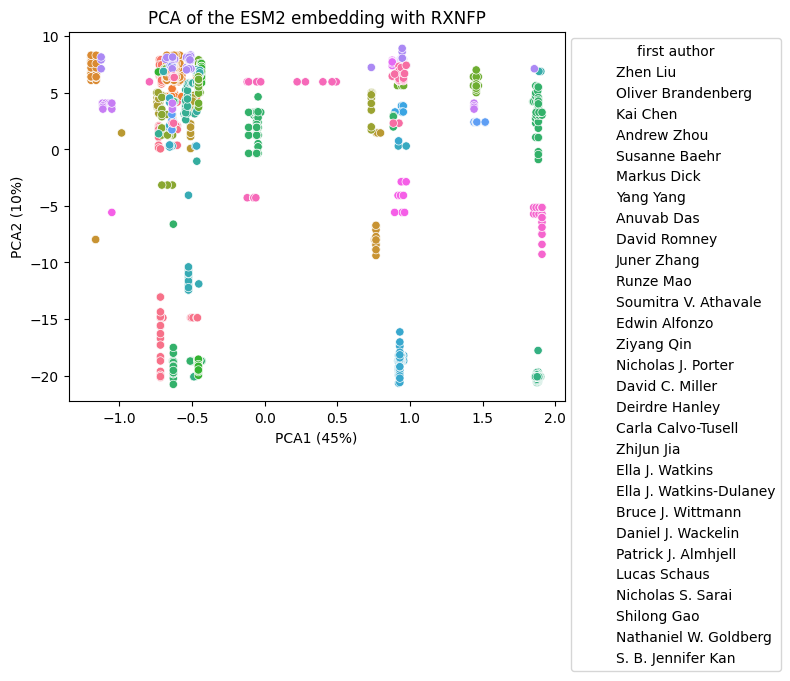

In [82]:
ax = sns.scatterplot(df, x='PCA1_protein_ESM3B', y='PCA1_reaction_rxnfp', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding with RXNFP')